# Import libraries

In [1]:
import scipy as sc
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl

# Add real data

In [2]:
# --- ADD OUR DATA for fsigma_8 ----

z_data = [0.02,0.067,0.1,0.17,0.35,0.77,0.25,0.37,0.22,0.41,0.6,0.6,0.78,0.57,0.3,0.4,0.5,0.8]
fsigma8_data = [0.36,0.423,0.37,0.51,0.44,0.49,0.351,0.46,0.42,0.45,0.43,0.433,0.38,0.427,0.407,0.419,0.427,0.47]
err_data = [0.04,0.055,0.13,0.06,0.05,0.18,0.058,0.038,0.07,0.04,0.04,0.067,0.04,0.066,0.055,0.041,0.043,0.08]

# Find growth rate f to first order

In [3]:
#---- USEFUL FUNCTIONS for growth rate f ----

# Define xi, caracteristic function of 4DEGB. xi(alpha_t = 1) = 1

def xi(x, cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k + \
                   alpha_tilde*(1 - 2*Omega_k + Omega_k**2)
    
    nom = 1 + 2*alpha_tilde*(Omega_lambda - Omega_k*np.exp(-2*x) -2*Omega_m*np.exp(-3*x) -3*Omega_r*np.exp(-4*x))
    denom = 1 + 2*alpha_tilde*(Omega_lambda + Omega_k*np.exp(-2*x) + Omega_m*np.exp(-3*x) + Omega_r*np.exp(-4*x))
    return nom/denom

# derivative of the growth rate f with the logarithm of the scale factor x = ln(a) 

def dfdx(f , x , cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k + \
                   alpha_tilde*(1 - 2*Omega_k + Omega_k**2)
    
    return (3*Omega_m*xi(x,cosmo)/(2*(Omega_m+Omega_r*np.exp(-x)+Omega_lambda*np.exp(3*x)+Omega_k*np.exp(x))) \
            - f**2 - (2-(3*Omega_m*np.exp(-3*x) + 4*Omega_r*np.exp(-4*x) + 2*Omega_k*np.exp(-2*x))/ \
                      (2*(Omega_k*np.exp(-2*x) + Omega_m*np.exp(-3*x) + Omega_r*np.exp(-4*x) + Omega_lambda)))*f)

#---- USEFUL FUNCTIONS for boundary condition ----

# correction due to large alpha_t
def Cort1(cosmo, z_BC):
    return 4*cosmo[4]*(cosmo[0] + cosmo[1])*((1+z_BC)**3) 

# correction due to DE
def Cort2(cosmo, z_BC):
    return(1 + cosmo[4] - (cosmo[0] + cosmo[1]))/((cosmo[0] + cosmo[1])*(1+z_BC)**3) 

def Cort3(cosmo, z_BC):
    return cosmo[3]*(1+z_BC)/(cosmo[0] + cosmo[1])

# Ensures we use the BCs only if we are at an initial redshift of matter domination
def BoundaryCondition(z_BC,cosmo):
    # ensure error message pops up if errors are too big
    if 1 < Cort1(cosmo, z_BC):
        ans = "Not in correct regime for apha_t to hold this assumption. We need alpha_t = ", 1/((4*(cosmo[0]  + cosmo[1])*(1+z_BC)**3))
    elif 1 < Cort2(cosmo, z_BC):
        ans = "Change initial conditions. Not in matter dominated era, with density ratios", (cosmo[0]  + cosmo[1])/(cosmo[3]*(1+z_BC)), \
        (cosmo[0]  + cosmo[1])*(1+z_BC)**3/(1 - (cosmo[0]  + cosmo[1]) - cosmo[2] - cosmo[3])
    
    # find errors if we are in matter dominated universe
    # see notes to see why BC_error = 6/5 corr_2 + 9/10 corr_
    else:
        ans = 1 - 3*Cort1(cosmo, z_BC)/2 - 6*Cort2(cosmo,z_BC)/11 - 2*Cort3(cosmo,z_BC)/3
    return ans

In [4]:
# ---- COSMOLOGY, SCALES AND BOUNDARY CONDITIONS -----

# Decide on some background cosmology

cosmo = [0.27 , 0.045, 0 ,9.227e-5 , 1e-3]                 #  Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde 
cosmo_LCDM_array = [0.27 , 0.045, 0 ,9.227e-5 , 0.0]
# Background cosmology for pyccl
cosmoLCDM = ccl.core.Cosmology(Omega_c=cosmo[0],
                               Omega_b=cosmo[1], 
                               sigma8=0.81,
                               h = 0.67,
                               n_s=0.96,
                               Omega_k=cosmo[2], 
                               Omega_g=cosmo[3])

# Decide on some coordinate times
p = 3
x = np.linspace( -2, 0 , int(10**p))
a = np.exp(x)
z = 1/a - 1

# integrate backwards as well
x1 = np.linspace(-2, -6 , int(10**p))
a1 = np.exp(x)
z1 = 1/a1 - 1


# create boundary condition for f: in matter dominated universe (Omg_m*(1+z)**3 >> Omg_l, Omg_m >> Omg_r*(1+z)) D(a) = a, f(a) = 1
z_BC = z[0] # Redshift our BC occurs at
print("z_BC = ", z_BC)
BC = BoundaryCondition(z_BC,cosmo)
BC_LCDM = BoundaryCondition(z_BC,cosmo_LCDM_array)
print("BC = ",BC)
print("alpha_t max = ",1/((4*(cosmo[0]  + cosmo[1])*(1+z_BC)**3)))
print("Corr1(alpha) = ",Cort1(cosmo, z_BC))
print("Corr2(DE) = ",Cort2(cosmo, z_BC))
print("Corr3(Rad) = ",Cort3(cosmo, z_BC))



# (approximate) error in boundary condition -- from equations we can tell this will be ~ O(err^2)
BC_err = Cort1(cosmo, z_BC)**2 + Cort2(cosmo, z_BC)**2 + Cort3(cosmo, z_BC)**2 + Cort1(cosmo, z_BC)*Cort2(cosmo, z_BC)\
         + Cort1(cosmo, z_BC)*Cort3(cosmo, z_BC) + Cort3(cosmo, z_BC)*Cort2(cosmo, z_BC)

# error in the boundary condition for equivalent LCDM universe
BC_err_LCDM = Cort2(cosmo_LCDM_array, z_BC)**2 + Cort3(cosmo_LCDM_array, z_BC)**2 + Cort3(cosmo, z_BC)*Cort2(cosmo, z_BC)

z_BC =  6.3890560989306495
BC =  0.23313218516501846
alpha_t max =  0.001967263632274888
Corr1(alpha) =  0.5083202798008462
Corr2(DE) =  0.005398171406962293
Corr3(Rad) =  0.0021644070039629555


In [5]:
# --- FINDING SOLUTIONS ------

# find solution with no correction - 4DEGB
f_nocorr = odeint(dfdx, 1, x, args=(cosmo,), mxstep=int(1e4))
f_nocorr = np.transpose(f_nocorr)[0]

#find solution with no correction - LCDM
f_LCDM_nocorr = odeint(dfdx, 1, x, args=(cosmo_LCDM_array,), mxstep=int(1e4))
f_LCDM_nocorr = np.transpose(f_LCDM_nocorr)[0]

#find solution - 4DEGB
f = odeint(dfdx, BC, x, args=(cosmo,), mxstep=int(1e4))
f = np.transpose(f)[0]

#find solution - LCDM
f_LCDM = odeint(dfdx, BC_LCDM, x, args=(cosmo_LCDM_array,), mxstep=int(1e4))
f_LCDM = np.transpose(f_LCDM)[0]

#find solution's theoretical error - 4DEGB
# Order of magnitude estimate of maximum BC if we assume ~ second order correction
f_max = odeint(dfdx, BC + BC_err, x, args=(cosmo,), mxstep=int(1e4))
f_max = np.transpose(f_max)[0]

f_min = odeint(dfdx, BC - BC_err, x, args=(cosmo,), mxstep=int(1e4))
f_min = np.transpose(f_min)[0]

#find solution's theoretical error - equivalent LCDM universe
# Order of magnitude estimate of maximum BC if we assume ~ second order correction
f_max_LCDM = odeint(dfdx, BC_LCDM + BC_err_LCDM, x, args=(cosmo_LCDM_array,), mxstep=int(1e4))
f_max_LCDM = np.transpose(f_max_LCDM)[0]

f_min_LCDM = odeint(dfdx, BC_LCDM - BC_err_LCDM, x, args=(cosmo_LCDM_array,), mxstep=int(1e4))
f_min_LCDM = np.transpose(f_min_LCDM)[0]

# Find growth rate f using Baker 2014

# Plot growth rate f and the fractional difference to LCDM

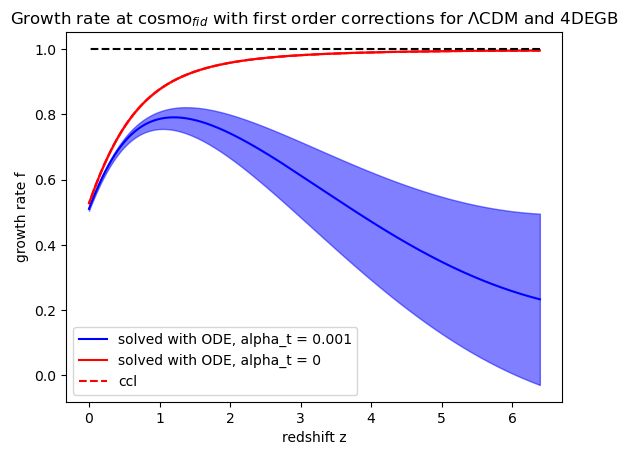

In [6]:
# plot of the growth rate with theoretical errors to to initial BC assumption, LDCM and 4DEGB
# function of z

plt.title(r"Growth rate at cosmo$_{fid}$ with first order corrections for $\Lambda$CDM and 4DEGB")
plt.plot(z,f, color = "b", label = r"solved with ODE, alpha_t = {}".format(cosmo[-1]))
plt.fill_between(z, f_min, f_max, alpha=0.5, edgecolor='b', facecolor='b')

plt.plot(z,f_LCDM, color = "r", label = "solved with ODE, alpha_t = 0")
plt.fill_between(z, f_min_LCDM, f_max_LCDM, alpha=0.5, edgecolor='r', facecolor='r')

plt.plot(z, ccl.growth_rate(cosmoLCDM,a), color = "r", linestyle='dashed', label = "ccl")

plt.plot(z, np.ones(len(z)), color = "black", linestyle = "dashed")
plt.xlabel("redshift z")
plt.ylabel("growth rate f")
#plt.xscale('log')
plt.legend()
#plt.plot(np.exp(x),f - ccl.growth_rate(cosmoLCDM,np.exp(x)))

#plt.savefig('growth_rate.pdf')  

plt.show()

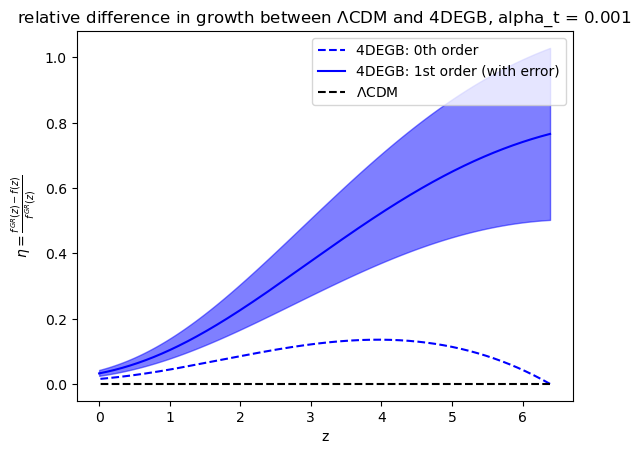

In [7]:
# Very approximate measure of relative error - can distinguish features

plt.plot(z, (f_LCDM_nocorr - f_nocorr)/f_LCDM_nocorr, color = "b", linestyle = "--", label = "4DEGB: 0th order")
plt.plot(z,(f_LCDM - f)/f_LCDM, color = "b", label = "4DEGB: 1st order (with error)")

plt.fill_between(z, (f_min_LCDM - f_min)/f_LCDM,
                    (f_max_LCDM - f_max)/f_LCDM, alpha=0.5, edgecolor='b', facecolor='b')

plt.plot(z, np.zeros(len(z)), color = "black", linestyle = "--", label = r"$\Lambda$CDM")

plt.xlabel("z")
plt.ylabel(r"$\eta = \frac{f^{GR}(z) - f(z)}{f^{GR}(z)}$")
plt.title(r"relative difference in growth between $\Lambda$CDM and 4DEGB, alpha_t = {}".format(cosmo[-1]))
plt.legend()
plt.show()

# Find Delta(a) and sigma8 to first order

In [8]:
#---- USEFUL FUNCTIONS for Delta(a) and sigma8 -----

# gives X(z) as defined in (8) Wang and Mota (note - k vanishes when calculating X)

def X(z, cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k + \
                   alpha_tilde*(1 - 2*Omega_k + Omega_k**2)
    
    return 1 + 4 * alpha_tilde * (Omega_m * (1 + z) ** 3 + Omega_r * (1 + z)** 4 + Omega_k * (1 + z) ** 2 + Omega_lambda)

# gives E(z) = H(z) / H0

def E(z , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k + \
                   alpha_tilde*(1 - 2*Omega_k + Omega_k**2)

    if alpha_tilde == 0:
        ans = np.sqrt(Omega_m * (1 + z) ** 3 + Omega_r * (1 + z) ** 4 + Omega_k * (1 + z) ** 2 + Omega_lambda)
    else:
        
        ans = np.sqrt((np.sqrt(X(z , cosmo)) - 1 + (2*alpha_tilde*Omega_k*(1+z)**2))/(2 * alpha_tilde))
    
    return ans

# Solves second order ODE for D_+(a)
def solverGrowth(y,a,cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde = cosmo
    Omega_m = Omega_c + Omega_b
    E_val = E(1/a - 1, cosmo)
    
    D , a3EdDda = y
    
    ydot = [a3EdDda / (E_val*a**3), 3*Omega_m*D*xi(np.log(a), cosmo)/(2*E_val*a**2)]
    return ydot

In [9]:
# ---- BOUNDARY CONDITIONS -------

# Can also do present day normalization as D(a = 1) = 1 (derivative?)
# Normalization to matter dominated epoc, D(a) = a * (1 - 3 Cort1 /2 -2 Cort2 /11)
# ======> dDda = 1 + 3 Cort1 - 8 Cort2 /11

Da_BC = a[0] * (1 - 3*Cort1(cosmo, z_BC)/2 - 2*Cort2(cosmo, z_BC)/11 + 2*Cort3(cosmo, z_BC)/3)
Da_BC_LCDM = a[0] * (1 - 2*Cort2(cosmo_LCDM_array, z_BC)/11 + 2*Cort3(cosmo_LCDM_array, z_BC)/3)
Da_BC_max = a[0] * (1 - 3*Cort1(cosmo, z_BC)/2 - 2*Cort2(cosmo, z_BC)/11 + 2*Cort3(cosmo, z_BC)/3 + BC_err)
Da_BC_min = a[0] * (1 - 3*Cort1(cosmo, z_BC)/2 - 2*Cort2(cosmo, z_BC)/11 + 2*Cort3(cosmo, z_BC)/3 - BC_err)
Da_BC_LCDM_max = a[0] * (1 - 2*Cort2(cosmo_LCDM_array, z_BC)/11 + 2*Cort3(cosmo_LCDM_array, z_BC)/3 + BC_err_LCDM)
Da_BC_LCDM_min = a[0] * (1 - 2*Cort2(cosmo_LCDM_array, z_BC)/11 + 2*Cort3(cosmo_LCDM_array, z_BC)/3 - BC_err_LCDM)

# BC for 4DEGB 
BCs = [Da_BC, (E(1/a[0] - 1, cosmo)*a[0]**3)* (1 + 3*Cort1(cosmo, z_BC) - 8*Cort2(cosmo, z_BC)/11)]

# Order of magnitude estimate of maximum BC if we assume ~ second order correction
BCs_max = [Da_BC_max, (E(1/a[0] - 1, cosmo)*a[0]**3)* (1 + 3*Cort1(cosmo, z_BC) 
             - 8*Cort2(cosmo, z_BC)/11 + Cort1(cosmo, z_BC)**2 + Cort2(cosmo, z_BC)**2)]

BCs_min = [Da_BC_min, (E(1/a[0] - 1, cosmo)*a[0]**3)* (1 + 3*Cort1(cosmo, z_BC) 
             - 8*Cort2(cosmo, z_BC)/11 - Cort1(cosmo, z_BC)**2 - Cort2(cosmo, z_BC)**2)]

# BC for LCDM
BCs_LCDM = [Da_BC_LCDM,
       (E(1/a[0] - 1, cosmo_LCDM_array)*a[0]**3)* (1 - 8*Cort2(cosmo_LCDM_array, z_BC)/11)]

# Order of magnitude estimate of maximum BC if we assume ~ second order correction
BCs_LCDM_max = [Da_BC_LCDM_max, (E(1/a[0] - 1, cosmo_LCDM_array)*a[0]**3)* (1 + 3*Cort1(cosmo_LCDM_array, z_BC) 
             - 8*Cort2(cosmo_LCDM_array, z_BC)/11 + Cort1(cosmo_LCDM_array, z_BC)**2 + Cort2(cosmo_LCDM_array, z_BC)**2)]

BCs_LCDM_min = [Da_BC_LCDM_min, (E(1/a[0] - 1, cosmo_LCDM_array)*a[0]**3)* (1 + 3*Cort1(cosmo_LCDM_array, z_BC) 
             - 8*Cort2(cosmo_LCDM_array, z_BC)/11 - Cort1(cosmo_LCDM_array, z_BC)**2 - Cort2(cosmo_LCDM_array, z_BC)**2)]

In [10]:
# ---- SOLUTIONS -------

#find solution with no correction - 4DEGB
Soln = odeint(solverGrowth, [a[0], (E(1/a[0] - 1, cosmo)*a[0]**3)], a, args=(cosmo,), mxstep=int(1e4))
Delta_nocorr = Soln.T[0]/Soln.T[0][-1]

#find solution with no correction - LCDM
Soln = odeint(solverGrowth, [a[0], (E(1/a[0] - 1, cosmo_LCDM_array)*a[0]**3)], a, args=(cosmo_LCDM_array,), mxstep=int(1e4))
Delta_LCDM_nocorr = Soln.T[0]/Soln.T[0][-1]

# 4DEGB solution
Soln = odeint(solverGrowth, BCs, a, args=(cosmo,), mxstep=int(1e4))
Delta = Soln.T[0]/Soln.T[0][-1]

# 4DEGB error
Soln = odeint(solverGrowth, BCs_max, a, args=(cosmo,), mxstep=int(1e4))
Delta_max = Soln.T[0]/Soln.T[0][-1]

Soln = odeint(solverGrowth, BCs_min, a, args=(cosmo,), mxstep=int(1e4))
Delta_min = Soln.T[0]/Soln.T[0][-1]

# LCDM solution
Soln = odeint(solverGrowth, BCs_LCDM, a, args=(cosmo_LCDM_array,), mxstep=int(1e4))
Delta_LCDM = Soln.T[0]/Soln.T[0][-1]

#LCDM error
Soln = odeint(solverGrowth, BCs_LCDM_max, a, args=(cosmo_LCDM_array,), mxstep=int(1e4))
Delta_LCDM_max = Soln.T[0]/Soln.T[0][-1]

Soln = odeint(solverGrowth, BCs_LCDM_min, a, args=(cosmo_LCDM_array,), mxstep=int(1e4))
Delta_LCDM_min = Soln.T[0]/Soln.T[0][-1]

# Plot Delta(a) and sigma8 and relative difference to LCDM

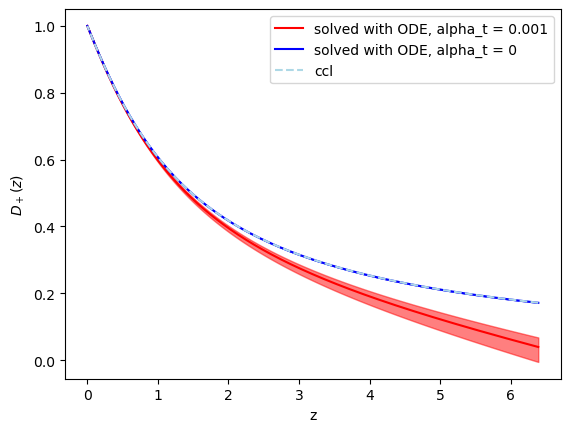

In [18]:
plt.plot(z, Delta, label  = r"solved with ODE, alpha_t = {}".format(cosmo[-1]), color = "r")
plt.fill_between(z, Delta_min, Delta_max, alpha=0.5, edgecolor='r', facecolor='r')

plt.plot(z, Delta_LCDM, label  = r"solved with ODE, alpha_t = 0", color = "blue")
plt.fill_between(z, Delta_LCDM_min, Delta_LCDM_max, alpha=0.5, edgecolor='blue', facecolor='blue')

plt.plot(z, ccl.growth_factor(cosmoLCDM,a), label = "ccl", color = "lightblue", linestyle ="--")
plt.legend()

plt.xlabel("z")
plt.ylabel(r"$D_+(z)$")

plt.show()

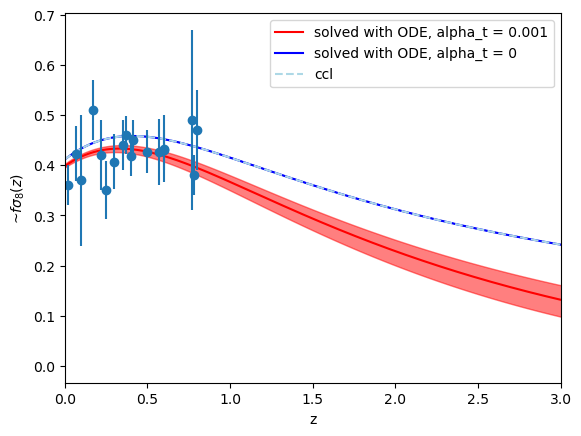

In [12]:
#for now just by eye. Will need primordial power spec to find
const = 0.41/0.525

plt.plot(z,const*f*Delta, label = r"solved with ODE, alpha_t = {}".format(cosmo[-1]), color = "r")
plt.fill_between(z, const*f_min*Delta_min, const*f_max*Delta_max, alpha=0.5, edgecolor='r', facecolor='r')

plt.plot(z,const*f_LCDM*Delta_LCDM, label = "solved with ODE, alpha_t = 0", color = "b")
plt.fill_between(z, const*f_min_LCDM*Delta_LCDM_min, const*f_max_LCDM*Delta_LCDM_max, alpha=0.5, edgecolor='b', facecolor='b')

plt.plot(z,const*ccl.growth_rate(cosmoLCDM,a)*ccl.growth_factor(cosmoLCDM,a), label = "ccl", color = "lightblue", linestyle ="--")
plt.legend()

# plot our data
plt.errorbar(z_data, fsigma8_data, yerr=err_data, fmt="o", label='data')

plt.xlabel("z")
plt.ylabel("~$f\sigma_8(z)$")
plt.xlim(0,3)
plt.show()

In [ ]:
# get correct factor in front of fsigma_8

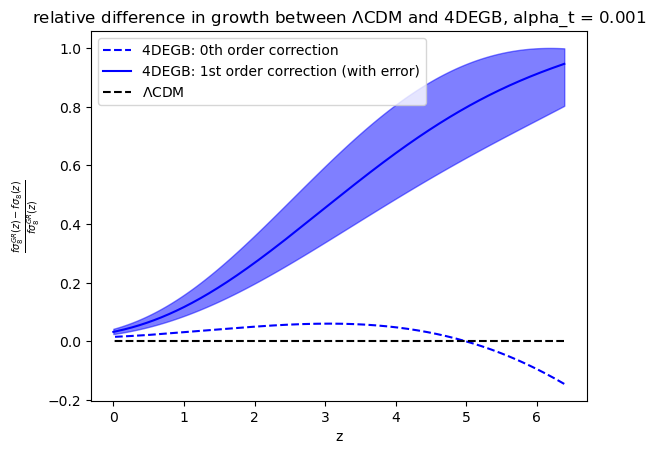

In [13]:
# Very approximate measure of relative error - can't distinguish features

plt.plot(z,(f_LCDM_nocorr*Delta_LCDM_nocorr - f_nocorr*Delta_nocorr)/(f_LCDM_nocorr*Delta_LCDM_nocorr) , color = "b",linestyle="--", label = "4DEGB: 0th order correction")
#plt.fill_between(z, 2*(f_LCDM_nocorr*Delta_LCDM_nocorr - f_nocorr*Delta_nocorr)/(f_LCDM_nocorr*Delta_LCDM_nocorr) - (f_LCDM*Delta_LCDM - f*Delta)/(f_LCDM*Delta_LCDM) ,
#                    (f_LCDM*Delta_LCDM - f*Delta)/(f_LCDM*Delta_LCDM), alpha=0.5, edgecolor='r', facecolor='r')

#plt.plot(z,(fsigma8_data*Delta_LCDM_nocorr - f_nocorr*Delta_nocorr)/(f_LCDM_nocorr*Delta_LCDM_nocorr) , color = "b")

plt.plot(z,(f_LCDM*Delta_LCDM - f*Delta)/(f_LCDM*Delta_LCDM) , color = "b", label = "4DEGB: 1st order correction (with error)")

plt.fill_between(z, (f_min_LCDM*Delta_LCDM_min - f_min*Delta_min)/(f_LCDM*Delta_LCDM) ,
                    (f_max_LCDM*Delta_LCDM_max - f_max*Delta_max)/(f_LCDM*Delta_LCDM), alpha=0.5, edgecolor='b', facecolor='b')

plt.plot(z,np.zeros(len(z)), color = "black", linestyle = "--", label = r"$\Lambda$CDM")
plt.xlabel("z")
plt.ylabel(r"$\frac{f\sigma_8^{GR}(z) - f\sigma_8(z)}{f\sigma_8^{GR}(z)}$")
plt.title(r"relative difference in growth between $\Lambda$CDM and 4DEGB, alpha_t = {}".format(cosmo[-1]))
plt.legend()
plt.show()

# Add-on: find transition redshifts bewtween different eras (DE, matter, alpha domination)

In [14]:
Omg_m_vals = 0.4
alpha_t_vals = np.linspace(0.005,0.05,50)

z_min = ((1 + alpha_t_vals - Omg_m_vals)/Omg_m_vals)**(1/3)-1
z_min_err = ((1 + alpha_t_vals - Omg_m_vals)/(0.2*Omg_m_vals))**(1/3)-1
z_max = (1/(4*alpha_t_vals*Omg_m_vals))**(1/3) -1
z_max_err = (0.2/(4*alpha_t_vals*Omg_m_vals))**(1/3) -1
print(z_min[0],z_min_err[0], z_max[0],z_max_err[0])

0.1478852123327774 0.9628561026349223 3.999999999999999 1.924017738212866


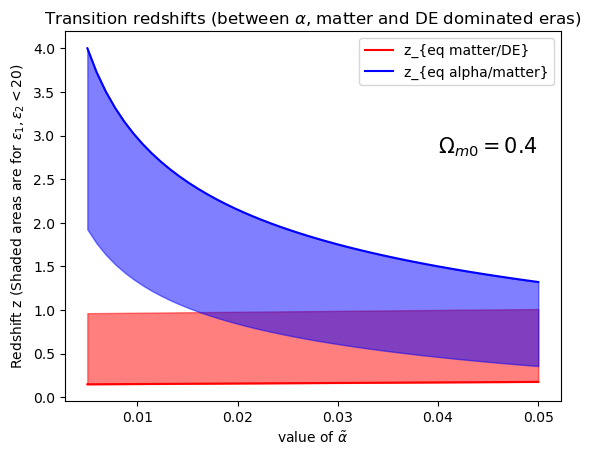

In [15]:
plt.plot(alpha_t_vals,z_min, label = r'z_{eq matter/DE}', color = "r")
plt.fill_between(alpha_t_vals, z_min_err , z_min , alpha=0.5, edgecolor='r', facecolor='r')

plt.plot(alpha_t_vals,z_max, label = r"z_{eq alpha/matter}", color = "b")
plt.fill_between(alpha_t_vals, z_max , z_max_err, alpha=0.5, edgecolor='b', facecolor='b')

plt.xlabel(r"value of $\tilde{\alpha}$")
plt.ylabel(r"Redshift z (Shaded areas are for $\epsilon_1, \epsilon_2 < 20%$)")
plt.title(r"Transition redshifts (between $\alpha$, matter and DE dominated eras)")

plt.text(0.04, 2.8, r"$\Omega_{m0} = 0.4$", color="black", fontsize=15)

plt.legend()

#plt.savefig('z_transition_alpha.pdf')  

plt.show()